# Pré-Traitements des données

1. Librairies et chargement données

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv("df-final2.csv",delimiter=",")
df.isna().sum().sum()

np.int64(0)

2. Premier traitement des données

In [ ]:
df=df.drop(columns=["player_id","season"])

df["minutesPlayed_UEFA"] = df.apply(lambda row: row["minutesPlayed"] if row["competition"] == "UEFA Champions League" else 0, axis=1)
df["goalsScored_UEFA"] = df.apply(lambda row: row["goalsScored"] if row["competition"] == "UEFA Champions League" else 0, axis=1)


In [ ]:
df = df.groupby("player_name").agg({
    "player_number": "first",
    "player_value": "first",
    "player_club": "first",
    "gamesPlayed": "sum",
    "goalsScored": "sum",
    "assists": "sum",
    "yellowCards": "sum",
    "redCards": "sum",
    "minutesPlayed": "sum",
    "minutesPlayed_UEFA": "sum",
    "goalsScored_UEFA": "sum",
    "position": "first",
    "age": "first",
    "player_league": "first",
    "transfer_fee": "first",
    "contract_end": "first",

}).reset_index()

In [ ]:
def convert_player_value(value):
    value = value.replace(" €", "").replace(",", ".").replace("mio.", "e6").replace("K", "e3").replace(" ", "")
    return int(float(eval(value)))

df["player_value"] = df["player_value"].apply(convert_player_value)

def clean_transfer_fee(value):
    if isinstance(value, str):
        value = value.replace(",", ".")
        if "mio" in value:
            return float(value.split()[0]) * 1_000_000
        elif "K" in value:
            return float(value.split()[0]) * 1_000
        elif value.strip() == "-" or value.strip().lower() == "nan":
            return 0
    return 0


df["transfer_fee"] = df["transfer_fee"].apply(clean_transfer_fee)

df['age'] = df['age'].str.extract(r'\((\d+)\)')



In [ ]:
def parse_remaining_years(date_str):
    # Couper la chaîne par espaces
    splitted = date_str.strip().split()
    if not splitted:
        return np.nan

    try:

        year = int(splitted[-1])
        return year - 2025
    except ValueError:
        return np.nan

df["remaining_years"] = df["contract_end"].apply(parse_remaining_years)
df.drop(columns=["contract_end"], inplace=True)



df.dropna(subset=["remaining_years"], inplace=True)




Convertir le type des varaibles

In [ ]:
df['player_value'] = df['player_value'].astype(int)
df['gamesPlayed'] = df['gamesPlayed'].astype(int)
df['goalsScored'] = df['goalsScored'].astype(int)
df['assists'] = df['assists'].astype(int)
df['yellowCards'] = df['yellowCards'].astype(int)
df['redCards'] = df['redCards'].astype(int)
df['minutesPlayed'] = df['minutesPlayed'].astype(int)
df['minutesPlayed_UEFA'] = df['minutesPlayed_UEFA'].astype(int)
df['goalsScored_UEFA'] = df['goalsScored_UEFA'].astype(int)
df['age'] = df['age'].astype(int)
df['transfer_fee'] = df['transfer_fee'].astype(int)
df['remaining_years'] = df['remaining_years'].astype(int)

In [ ]:
df.head(5)


####

df_test_value = df.copy()

###

# Visualisation

Librairies

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

1. Comparaison entre prix réel et prix TF

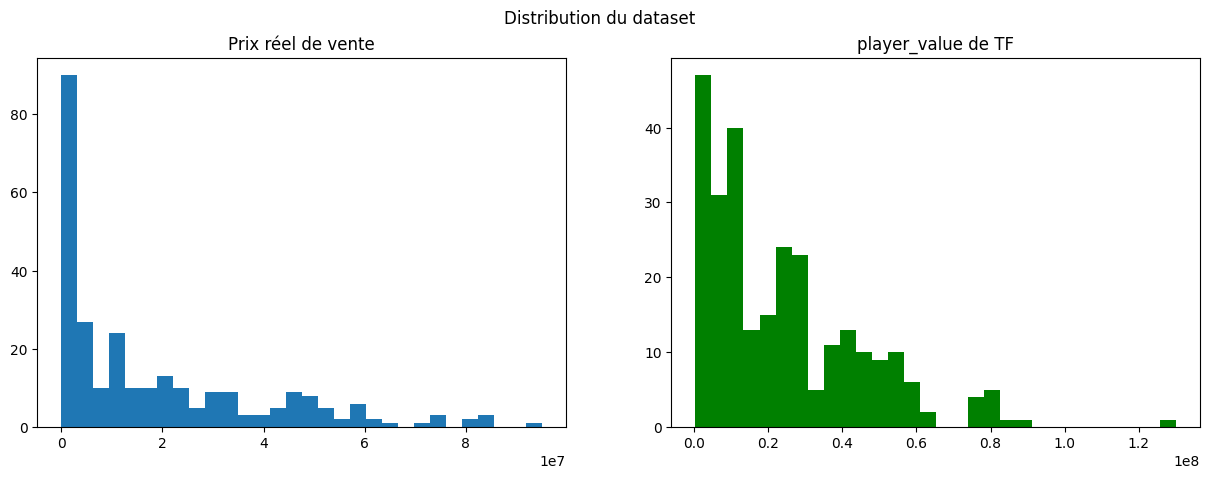

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Distribution du dataset')
fig.set_figwidth(15)

ax1.hist(df['transfer_fee'], bins=30)
ax1.set_title('Prix réel de vente')

ax2.hist(df['player_value'],color='green', bins=30)
ax2.set_title('player_value de TF')

fig.show()

2. Distrubution du Dataset

(array([112.,  62.,  46.,   0.,  19.,  11.,   0.,   6.,   4.,   0.,   3.,
          2.,   0.,   2.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.   ,  0.675,  1.35 ,  2.025,  2.7  ,  3.375,  4.05 ,  4.725,
         5.4  ,  6.075,  6.75 ,  7.425,  8.1  ,  8.775,  9.45 , 10.125,
        10.8  , 11.475, 12.15 , 12.825, 13.5  , 14.175, 14.85 , 15.525,
        16.2  , 16.875, 17.55 , 18.225, 18.9  , 19.575, 20.25 , 20.925,
        21.6  , 22.275, 22.95 , 23.625, 24.3  , 24.975, 25.65 , 26.325,
        27.   ]),
 <BarContainer object of 40 artists>)

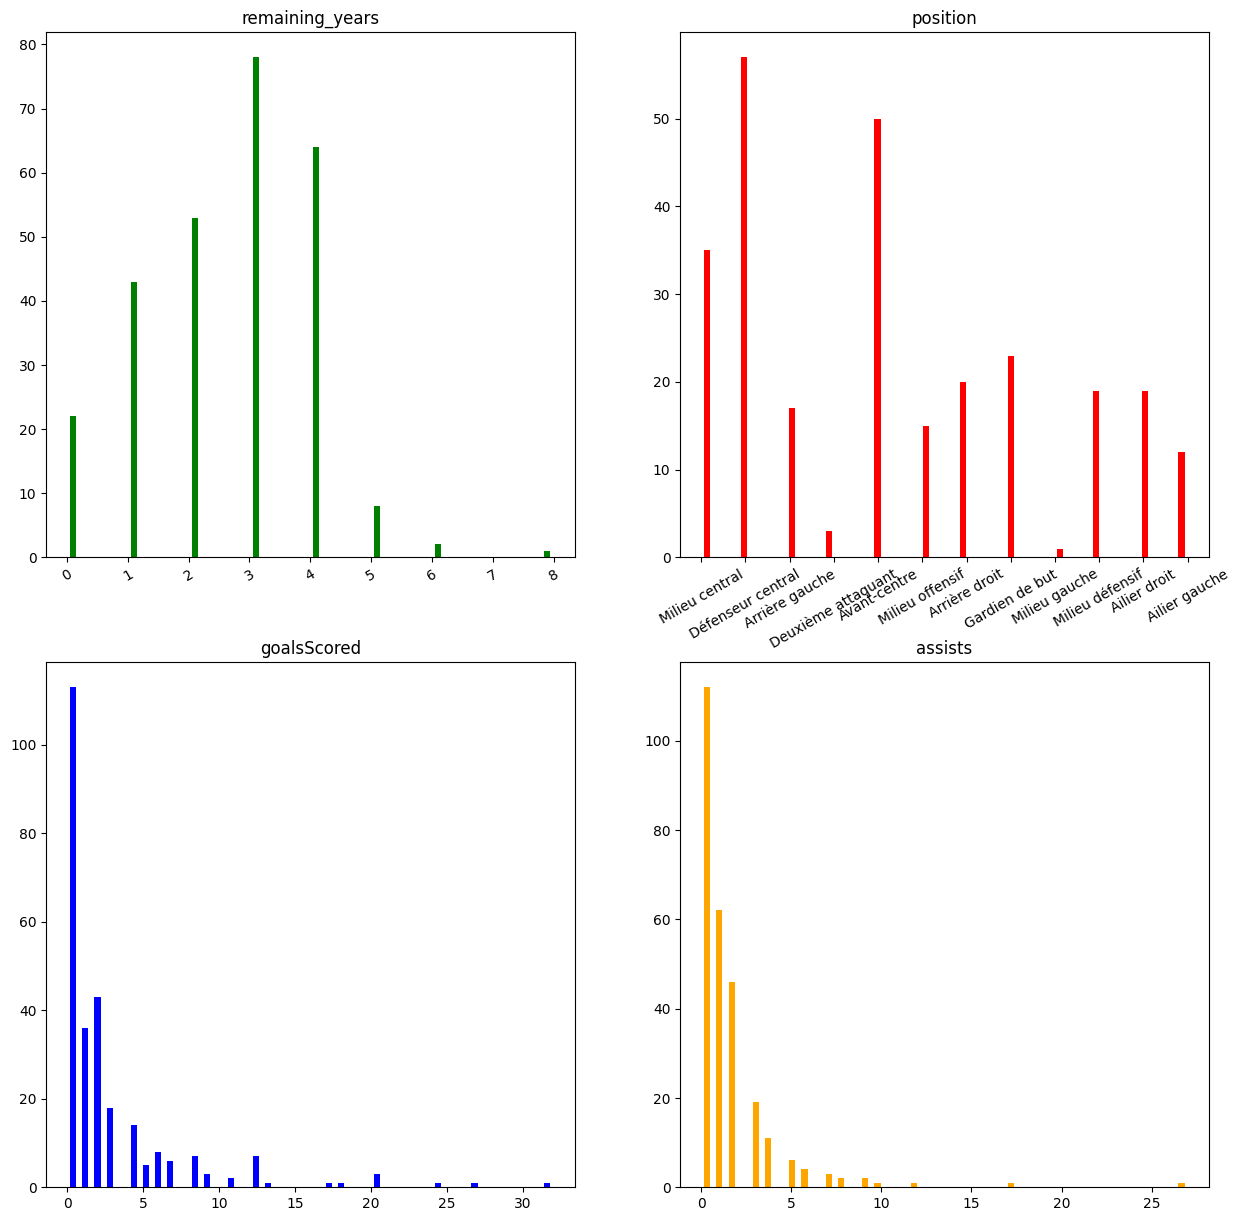

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(15)

axs[0,0].set_title("remaining_years")
axs[0,0].hist(df['remaining_years'], color='green', rwidth=0.5, bins=40)
axs[0, 0].tick_params(axis='x', rotation=30)

axs[0,1].set_title("position")
axs[0,1].hist(df['position'], color='red', rwidth=0.5, bins=40)
axs[0, 1].tick_params(axis='x', rotation=30)
axs[1,0].set_title("goalsScored")
axs[1,0].hist(df['goalsScored'], color='blue', rwidth=0.5, bins=40)
axs[1,1].set_title("assists")
axs[1,1].hist(df['assists'], color='orange', rwidth=0.5, bins=40)



3.Répartition des clubs

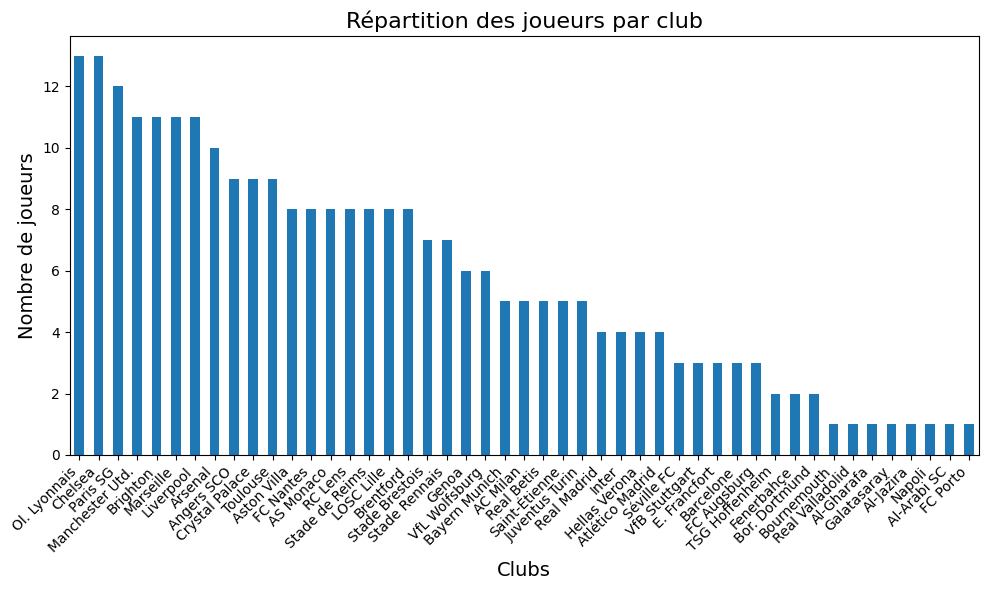

In [ ]:
club_counts = df['player_club'].value_counts()

plt.figure(figsize=(10, 6))
club_counts.plot(kind='bar')

plt.title('Répartition des joueurs par club', fontsize=16)
plt.xlabel('Clubs', fontsize=14)
plt.ylabel('Nombre de joueurs', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Feature Engineering

Librairies

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

1.Suppression de certaines features

In [ ]:
df = df.drop(df[df["player_club"] == "E. Francfort"].index)
df = df.drop(df[df["player_club"] == "Manchester City"].index)

names = df["player_name"].copy()
df = df.set_index('player_name', drop=True)
df = df.drop(columns=[ 'player_number'])
df=df.drop(columns=["redCards"])




2.Classification des clubs par catégories

In [ ]:
encoded2 = pd.get_dummies(df['position'])
df = pd.concat([df.drop(columns=['position']), encoded2], axis=1)


club_mapping = {
    # Tier A
    "Arsenal": "A",
    "Atlético Madrid": "A",
    "Barcelone": "A",
    "Chelsea": "A",
    "Liverpool": "A",
    "Manchester Utd.": "A",
    "Napoli": "A",
    "Paris SG": "A",
    "Real Madrid": "A",
    "Tottenham": "A",
    "Manchester City": "A",
    "AC Milan":"A",
    "Juventus Turin":"A",
    "Aston Villa": "A",
    "Brighton": "A",



    # Tier B
    "Roma": "B",
    "AS Monaco": "B",
    "Brentford": "B",
    "Crystal Palace": "B",
    "FC Porto": "B",
    "Fenerbahçe": "B",
    "LOSC Lille": "B",
    "Marseille": "B",
    "Ol. Lyonnais": "B",
    "Real Betis": "B",
    "Stade Rennais": "B",
    "Séville FC":"B",
    "E. Francfort":"B",
    "VfB Stuttgart":"B",
    "Borussia Dortmund":"B",
    "VfL Wolfsburg":"B",
    "Galatasaray":"B",
    "RC Lens": "B",


    # Tier C

    "Al-Arabi SC": "C",
    "Al-Gharafa": "C",
    "Al-Jazira": "C",
    "Angers SCO": "C",
    "Bournemouth": "C",
    "FC Nantes": "C",
    "Real Valladolid": "C",
    "Saint-Étienne": "C",
    "Stade Brestois": "C",
    "Stade de Reims": "C",
    "Toulouse": "C",
    "Bournemouth": "C",
    "Genoa":"C",
    "Hellas Verona":"C",
    "FC Augsburg":"C",
    "TSG Hoffenheim":"C",
}

def map_club_to_category(club_name):

    return club_mapping.get(club_name, "C")

# On applique au DataFrame
df["club_category"] = df["player_club"].apply(map_club_to_category)

# on retire la colonne "club"
df.drop(columns=["player_club"], inplace=True)

# On transforme 'club_category' en dummies
df = pd.get_dummies(df, columns=["club_category"], drop_first=False)

encoded3 = pd.get_dummies(df['player_league'])
df = pd.concat([df.drop(columns=['player_league']), encoded3], axis=1)

3. Scaling des Features Numériques

In [ ]:
#df["remaining_years"] = df["remaining_years"].replace(0, 1e-6)

#df["remaining_years"] = np.log(df["remaining_years"])


In [ ]:
scaler = StandardScaler()
columns=["minutesPlayed","gamesPlayed","goalsScored","assists","yellowCards","minutesPlayed_UEFA","goalsScored_UEFA","age","remaining_years","transfer_fee","remaining_years"]#"remaining_years"
temp1=df[columns]
df[columns] = scaler.fit_transform(temp1)

df = df[df["transfer_fee"] > 0]



In [ ]:
y = df['player_value']
X = df.drop(columns=['player_value'])

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


4. Regrouper par Poste: (réduire complexité du modèle)

In [ ]:
X['Gardien'] = X['Gardien de but']

X['Défenseur'] = (
  X['Arrière droit'] +
  X['Arrière gauche'] +
  X['Défenseur central']
)

X['Milieu'] = (
  X['Milieu central'] +
  X['Milieu défensif'] +
  X['Milieu offensif']
)

X['Attaquant'] = (
  X['Ailier droit'] +
  X['Ailier gauche'] +
  X['Avant-centre'] +
  X['Deuxième attaquant']
)


X = X.drop(columns=['Gardien de but', 'Arrière droit', 'Arrière gauche', 'Défenseur central','Milieu central', 'Milieu défensif', 'Milieu offensif',
 'Ailier droit', 'Ailier gauche', 'Avant-centre', 'Deuxième attaquant'])


5.Final DataSet

In [ ]:
X.head(5)

,gamesPlayed,goalsScored,assists,yellowCards,minutesPlayed,minutesPlayed_UEFA,goalsScored_UEFA,age,transfer_fee,remaining_years,...,Ligue 1,Premier League,Serie A,Stars League,Süper Lig,UAE Pro League,Gardien,Défenseur,Milieu,Attaquant
player_name,,,,,,,,,,,,,,,,,,,,,
Aleksandr Golovin,0.004618,-0.145639,-0.217825,-0.465768,0.079380,1.336970,-0.277989,0.798805,0.535175,1.034293,...,True,False,False,False,False,False,False,False,True,False
Alexander Sørloth,0.375907,1.170022,0.158801,-0.802225,-0.125199,0.426283,-0.277989,1.079750,0.628899,0.310558,...,False,False,False,False,False,False,False,False,False,True
Alisson,-0.366670,-0.584193,-0.594451,-0.802225,-0.098724,0.696643,-0.277989,1.922584,2.058194,-0.413177,...,False,True,False,False,False,False,True,False,False,False
Amadou Onana,-0.057263,0.073638,-0.594451,0.207147,-0.090702,0.340906,1.029048,-0.605918,1.910578,1.034293,...,False,True,False,False,False,False,False,False,True,False
Amine Gouiri,-0.181026,-0.145639,-0.217825,-0.465768,-0.306513,-0.584011,-0.277989,-0.324973,0.441450,-0.413177,...,True,False,False,False,False,False,False,False,False,True


In [ ]:
correlation_matrix = X.corrwith(y)
print(correlation_matrix)

gamesPlayed           0.081326
goalsScored           0.428710
assists               0.407207
yellowCards           0.101498
minutesPlayed         0.235357
minutesPlayed_UEFA    0.314945
goalsScored_UEFA      0.542438
age                   0.052576
transfer_fee          0.618134
remaining_years       0.082883
Milieu gauche              NaN
club_category_A       0.256144
club_category_B      -0.405067
club_category_C       0.142021
Bundesliga            0.012102
LaLiga                0.213532
Liga Portugal              NaN
Ligue 1              -0.224480
Premier League       -0.018998
Serie A               0.113557
Stars League               NaN
Süper Lig            -0.102064
UAE Pro League             NaN
Gardien              -0.180901
Défenseur            -0.110124
Milieu                0.091329
Attaquant             0.112668
dtype: float64


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# Prediction

In [ ]:
kfold = KFold(n_splits=6, shuffle=True, random_state=42)

#model = LinearRegression()
model = Ridge(alpha=6)


train_scores = []
test_scores = []

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_scores.append(train_r2)
    test_scores.append(test_r2)

## Evaluation score

R2 score:

In [ ]:
mean_train_r2 = np.mean(train_scores)
std_train_r2 = np.std(train_scores)
mean_test_r2 = np.mean(test_scores)
std_test_r2 = np.std(test_scores)

print("La performance du model pour le training set")
print("--------------------------------------")
print('Mean R2 score est {:.4f} ± {:.4f}'.format(mean_train_r2, std_train_r2))

print("\nLa performance du modelpour le testing set")
print("--------------------------------------")
print('Mean R2 score est {:.4f} ± {:.4f}'.format(mean_test_r2, std_test_r2))

La performance du model pour le training set
--------------------------------------
Mean R2 score est 0.6643 ± 0.0260

La performance du modelpour le testing set
--------------------------------------
Mean R2 score est 0.3461 ± 0.3323


Distribution des résidus:

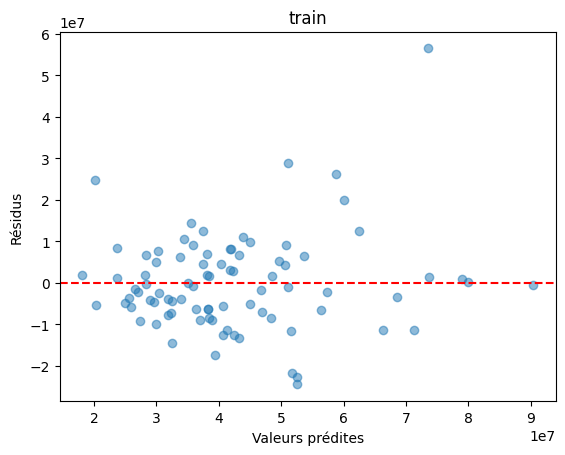

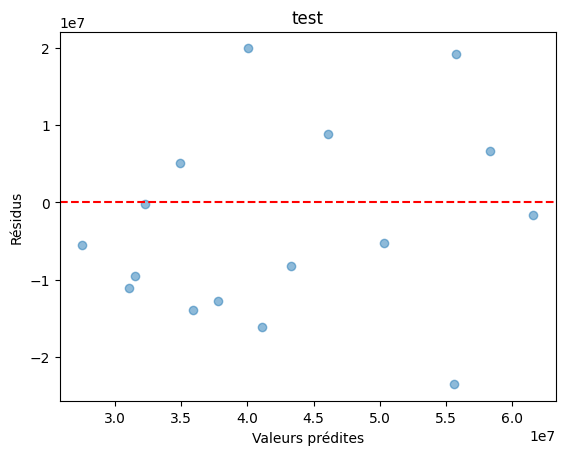

In [ ]:
resid_train = y_train - y_train_pred

resid_test = y_test - y_test_pred

# Tracé des résidus pour l'ensemble d'entraînement
plt.scatter(y_train_pred, resid_train, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('train')
plt.show()

plt.scatter(y_test_pred, resid_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('test')
plt.show()

In [ ]:
df

,player_value,gamesPlayed,goalsScored,assists,yellowCards,minutesPlayed,minutesPlayed_UEFA,goalsScored_UEFA,age,transfer_fee,...,club_category_C,Bundesliga,LaLiga,Liga Portugal,Ligue 1,Premier League,Serie A,Stars League,Süper Lig,UAE Pro League
player_name,,,,,,,,,,,,,,,,,,,,,
Aleksandr Golovin,30000000,0.004618,-0.145639,-0.217825,-0.465768,0.079380,1.336970,-0.277989,0.798805,0.535175,...,False,False,False,False,True,False,False,False,False,False
Alexander Sørloth,25000000,0.375907,1.170022,0.158801,-0.802225,-0.125199,0.426283,-0.277989,1.079750,0.628899,...,False,False,True,False,False,False,False,False,False,False
Alisson,25000000,-0.366670,-0.584193,-0.594451,-0.802225,-0.098724,0.696643,-0.277989,1.922584,2.058194,...,False,False,False,False,False,True,False,False,False,False
Amadou Onana,55000000,-0.057263,0.073638,-0.594451,0.207147,-0.090702,0.340906,1.029048,-0.605918,1.910578,...,False,False,False,False,False,True,False,False,False,False
Amine Gouiri,20000000,-0.181026,-0.145639,-0.217825,-0.465768,-0.306513,-0.584011,-0.277989,-0.324973,0.441450,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yankuba Minteh,28000000,-0.181026,-0.145639,-0.217825,0.207147,-0.453328,-0.584011,-0.277989,-1.448752,0.769485,...,False,False,False,False,False,True,False,False,False,False
Youssef En-Nesyri,22000000,0.314025,1.389298,0.535428,-0.129310,-0.093911,-0.584011,-0.277989,0.517861,0.043122,...,False,False,False,False,False,False,False,False,True,False
Youssouf Fofana,30000000,0.314025,-0.364916,1.665307,1.216520,0.548709,1.839746,-0.277989,-0.044029,0.066553,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
df_test_value[df_test_value["player_name"]== "Andy Diouf"]

,player_name,player_number,player_value,player_club,gamesPlayed,goalsScored,assists,yellowCards,redCards,minutesPlayed,minutesPlayed_UEFA,goalsScored_UEFA,position,age,player_league,transfer_fee,remaining_years
25,Andy Diouf,18,10000000,RC Lens,18,1,1,2,0,1298,0,0,Milieu central,21,Ligue 1,14000000,3


In [ ]:
import pandas as pd
y_pred_test = model.predict(X_test)
preds_test = pd.DataFrame({
    'PlayerName': X_test.index,     # l’index contient les noms
    'y_true': y_test.values,
    'y_pred': y_pred_test
}).set_index('PlayerName')

preds_test.head(20)

,y_true,y_pred
PlayerName,,
Alexander Sørloth,25000000,3.780121e+07
Alisson,25000000,4.113696e+07
Bremer,60000000,4.008131e+07
Dani Olmo,60000000,6.158140e+07
Darwin Núñez,65000000,5.830007e+07
Davide Frattesi,32000000,5.556354e+07
Kevin Schade,22000000,2.754294e+07
Khéphren Thuram,35000000,4.329334e+07
Lucas Hernández,32000000,3.226371e+07


In [ ]:
def predict_by_name(player_name: str):
    row = X.loc[[player_name]]  # garde un DataFrame (double [])
    pred = model.predict(row)[0]
    return pred

# Exemple
predict_by_name("Virgil van Dijk")

np.float64(52458869.31559275)

In [ ]:
preds_test.to_csv("resultat.csv", index=False)